<a href="https://colab.research.google.com/github/senguptashritama/Multilabel-Classification-of-ResearchPapers/blob/main/KNN_ClassifierChains.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Loading required libraries and preprocessed dataset

In [ ]:
! pip install scikit-multilearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 1.1 MB/s eta 0:00:00


In [ ]:
import gensim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from skmultilearn.problem_transform import ClassifierChain
from sklearn.metrics import classification_report, accuracy_score,f1_score. confusion_matrix, roc_curve, roc_auc_score, auc

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/archive (4)/filtered_data.csv")
df.head()

,titles,summaries,terms
0,survey semantic stereo match semantic depth ...,stereo match one widely use technique infer de...,"['cs.CV', 'cs.LG']"
1,futureai guide principle consensus recommend...,recent advancement artificial intelligence a...,"['cs.CV', 'cs.AI', 'cs.LG']"
2,enforce mutual consistency hard region semisup...,paper propose novel mutual consistency netwo...,"['cs.CV', 'cs.AI']"
3,parameter decoupling strategy semisupervise 3d...,consistency training prove advanced semisuperv...,['cs.CV']
4,backgroundforeground segmentation interior sen...,ensure safety automate drive correct percept...,"['cs.CV', 'cs.LG']"


### Creating word embedding of the input text (titles and summaries) using Word2Vec

In [ ]:
df['text'] = df['titles'] + ' ' + df['summaries']

df['tokens'] = df['text'].apply(word_tokenize)
model = Word2Vec(sentences= df['tokens'], vector_size=100, window=5, min_count=1, sg=0)
model.save("word2vec_arxiv.model")

In [ ]:
word2vec_model = Word2Vec.load("word2vec_arxiv.model")

def text_to_vectors(text, word2vec_model):
    words = text.split()
    vector = np.zeros(word2vec_model.vector_size)
    for word in words:
        if word in word2vec_model.wv:
            vector += word2vec_model.wv[word]
    if np.count_nonzero(vector) == 0:
        return vector
    else:
        return vector / np.linalg.norm(vector)

df["titles"] = df["titles"].apply(lambda x: text_to_vectors(x, word2vec_model))
df["summaries"] = df["summaries"].apply(lambda x: text_to_vectors(x, word2vec_model))

### Encoding target variable using MultilabelBinarizer

In [ ]:
terms_split = df['terms'].str.strip('][').str.split(', ')

mlb = MultiLabelBinarizer()
y_encoded = pd.DataFrame(mlb.fit_transform(terms_split), columns=mlb.classes_)

### Merging the encoded columns to one dataframe

In [ ]:
combined_data = pd.concat([df, y_encoded], axis=1)

### Preparing predictor variables (X) and target variables (Y) for model training

In [ ]:
x_data = combined_data[['titles','summaries']].values
X =  np.array(x_data.tolist())
X = X.reshape(X.shape[0], -1)

In [ ]:
y_data = combined_data[['cs.AI','cs.CV','cs.LG','eess.IV','stat.ML']].values
y =  np.array(y_data.tolist())

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Calculating costs based on class frequencies

In [ ]:
class_frequencies = y_train.mean(axis=0)
label_costs = 1 / class_frequencies

### Model Training

A KNeighborsClassifier with 10 neighbors is defined as the base classifier.
ClassifierChain is then applied to create a multi-label classifier using the base classifier.
Finally, the multi-label classifier is trained on the provided training data (X_train, y_train) using the fit method.

In [ ]:
base_classifier = KNeighborsClassifier(n_neighbors=10)
mlknn_classifier = ClassifierChain(base_classifier)

mlknn_classifier.fit(X_train, y_train)

ClassifierChain(classifier=KNeighborsClassifier(n_neighbors=10),
                require_dense=[True, True])

In [ ]:
y_pred = mlknn_classifier.predict(X_test)
y_pred

<5642x5 sparse matrix of type '<class 'numpy.float64'>'
	with 7782 stored elements in Compressed Sparse Column format>

In [ ]:
y_pred_dense = y_pred.toarray()


y_pred_list = y_pred_dense.tolist()
for i in range(min(20, y_pred.shape[0])):
    print("Sample", i+1, "Predicted Labels:", y_pred_list[i])

Sample 1 Predicted Labels: [0.0, 0.0, 1.0, 0.0, 1.0]
Sample 2 Predicted Labels: [0.0, 1.0, 0.0, 0.0, 0.0]
Sample 3 Predicted Labels: [0.0, 0.0, 1.0, 0.0, 1.0]
Sample 4 Predicted Labels: [0.0, 1.0, 0.0, 0.0, 0.0]
Sample 5 Predicted Labels: [0.0, 1.0, 0.0, 0.0, 0.0]
Sample 6 Predicted Labels: [0.0, 1.0, 0.0, 0.0, 0.0]
Sample 7 Predicted Labels: [0.0, 0.0, 1.0, 0.0, 1.0]
Sample 8 Predicted Labels: [0.0, 1.0, 0.0, 0.0, 0.0]
Sample 9 Predicted Labels: [0.0, 0.0, 1.0, 0.0, 1.0]
Sample 10 Predicted Labels: [0.0, 1.0, 0.0, 0.0, 0.0]
Sample 11 Predicted Labels: [0.0, 1.0, 0.0, 0.0, 0.0]
Sample 12 Predicted Labels: [0.0, 0.0, 1.0, 0.0, 1.0]
Sample 13 Predicted Labels: [0.0, 1.0, 0.0, 0.0, 0.0]
Sample 14 Predicted Labels: [1.0, 0.0, 1.0, 0.0, 1.0]
Sample 15 Predicted Labels: [0.0, 0.0, 1.0, 0.0, 1.0]
Sample 16 Predicted Labels: [0.0, 1.0, 0.0, 0.0, 0.0]
Sample 17 Predicted Labels: [0.0, 0.0, 1.0, 0.0, 1.0]
Sample 18 Predicted Labels: [0.0, 1.0, 0.0, 0.0, 0.0]
Sample 19 Predicted Labels: [0.0, 1.0

In [ ]:
label_mapping = {0: 'cs.AI', 1: 'cs.CV', 2: 'cs.LG', 3: 'eess.IV', 4: 'stats.ML'}

for i in range(min(20, y_test.shape[0])):
    actual_labels = [label_mapping[j] for j in range(y_test.shape[1]) if y_test[i, j] == 1]
    predicted_labels = [label_mapping[j] for j in range(y_pred_dense.shape[1]) if y_pred_dense[i, j] == 1]
    print("Sample", i+1)
    print("Actual Labels:", actual_labels)
    print("Predicted Labels:", predicted_labels)
    print()

Sample 1
Actual Labels: ['cs.LG', 'stats.ML']
Predicted Labels: ['cs.LG', 'stats.ML']

Sample 2
Actual Labels: ['cs.CV']
Predicted Labels: ['cs.CV']

Sample 3
Actual Labels: ['cs.AI', 'cs.LG', 'stats.ML']
Predicted Labels: ['cs.LG', 'stats.ML']

Sample 4
Actual Labels: ['cs.CV']
Predicted Labels: ['cs.CV']

Sample 5
Actual Labels: ['cs.CV', 'eess.IV']
Predicted Labels: ['cs.CV']

Sample 6
Actual Labels: ['cs.CV']
Predicted Labels: ['cs.CV']

Sample 7
Actual Labels: ['cs.LG']
Predicted Labels: ['cs.LG', 'stats.ML']

Sample 8
Actual Labels: ['cs.CV']
Predicted Labels: ['cs.CV']

Sample 9
Actual Labels: ['cs.LG', 'stats.ML']
Predicted Labels: ['cs.LG', 'stats.ML']

Sample 10
Actual Labels: ['cs.CV']
Predicted Labels: ['cs.CV']

Sample 11
Actual Labels: ['cs.CV', 'cs.LG']
Predicted Labels: ['cs.CV']

Sample 12
Actual Labels: ['cs.CV', 'cs.LG', 'stats.ML']
Predicted Labels: ['cs.LG', 'stats.ML']

Sample 13
Actual Labels: ['cs.CV']
Predicted Labels: ['cs.CV']

Sample 14
Actual Labels: ['cs.A

This model can capture more than 2 labels for an instance which is an improvement from SVC and Random Forest

### Model Evaluation

1) ROC Curve

2) Balanced overall accuracy and F1 score

3) Confusion matrix for each label

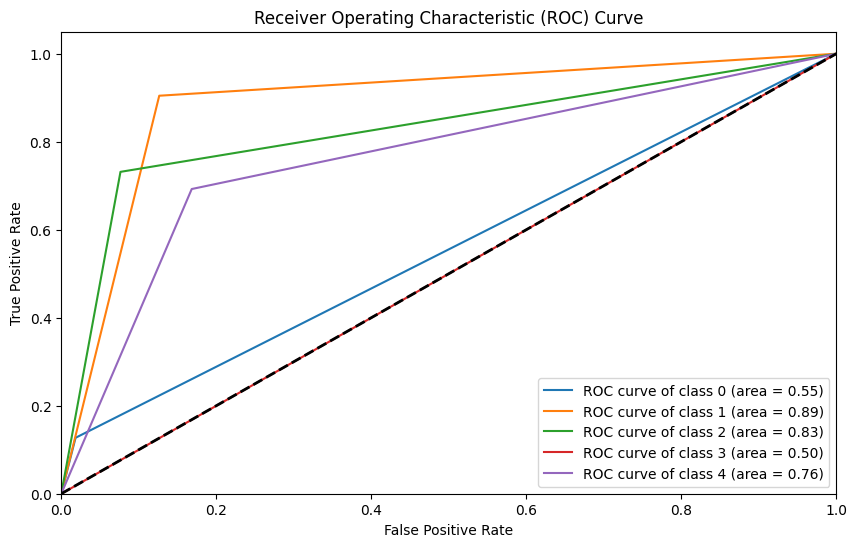

In [ ]:
y_pred_dense = y_pred.toarray()

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(y_test.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_dense[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 6))
for i in range(y_test.shape[1]):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
balanced_acc_scores = []
for i in range(y_test.shape[1]):
    balanced_acc_scores.append(accuracy_score(y_test[:, i], y_pred_dense[:, i]))

average_balanced_acc_score = np.mean(balanced_acc_scores)

print("Average Balanced Accuracy Score:", average_balanced_acc_score)

Average Balanced Accuracy Score: 0.8652605459057072


In [ ]:
f1_scores = []
for i in range(y_test.shape[1]):
    f1_scores.append(f1_score(y_test[:, i], y_pred_dense[:, i]))

average_f1_score = np.mean(f1_scores)

print("Average F1 Score:", average_f1_score)

Average F1 Score: 0.5171563683057947


In [ ]:
conf_matrices = []

for i in range(y_test.shape[1]):
    conf_matrices.append(confusion_matrix(y_test[:, i], y_pred_dense[:, i]))

for i, conf_matrix in enumerate(conf_matrices):
    print("Confusion Matrix for Label", i)
    print(conf_matrix)

for i, conf_matrix in enumerate(conf_matrices):
    tn, fp, fn, tp = conf_matrix.ravel()
    print("For Label", i)
    print("True Positives (TP):", tp)
    print("False Positives (FP):", fp)
    print("True Negatives (TN):", tn)
    print("False Negatives (FN):", fn)
    print()

Confusion Matrix for Label 0
[[4789   90]
 [ 666   97]]
Confusion Matrix for Label 1
[[1790  259]
 [ 343 3250]]
Confusion Matrix for Label 2
[[2600  215]
 [ 759 2068]]
Confusion Matrix for Label 3
[[5349    1]
 [ 292    0]]
Confusion Matrix for Label 4
[[3340  676]
 [ 500 1126]]
For Label 0
True Positives (TP): 97
False Positives (FP): 90
True Negatives (TN): 4789
False Negatives (FN): 666

For Label 1
True Positives (TP): 3250
False Positives (FP): 259
True Negatives (TN): 1790
False Negatives (FN): 343

For Label 2
True Positives (TP): 2068
False Positives (FP): 215
True Negatives (TN): 2600
False Negatives (FN): 759

For Label 3
True Positives (TP): 0
False Positives (FP): 1
True Negatives (TN): 5349
False Negatives (FN): 292

For Label 4
True Positives (TP): 1126
False Positives (FP): 676
True Negatives (TN): 3340
False Negatives (FN): 500



**Final Note -**

**Average Balanced Accuracy Score:** The model achieves an average balanced accuracy score of approximately 0.865, indicating its ability to effectively classify instances across different labels while considering class imbalance.

**Average F1 Score:** The average F1 score of around 0.517 indicates a moderate balance between precision and recall across all labels.

**Confusion Matrices:**

**Label 0:** The model correctly identifies 97 true positives but also encounters 90 false positives and 666 false negatives.

**Label 1:** It performs reasonably well with 3250 true positives and 1790 true negatives, but with 259 false positives and 343 false negatives.

**Label 2:** The model shows decent performance with 2068 true positives and 2600 true negatives, while experiencing 215 false positives and 759 false negatives.

**Label 3:** This label presents a challenge as it correctly identifies no true positives and only one true negative, while missing 292 true positives and having one false positive.

**Label 4:** The model exhibits fair performance here, achieving 1126 true positives and 3340 true negatives, with 676 false positives and 500 false negatives.